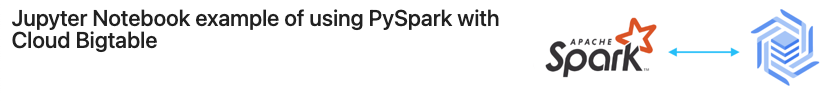

In this example, we demonstrate using the Spark-Bigtable connector to interact
with Bigtable using a Jupyter notebook inside a Dataproc cluster. 

This example generates and stores mock data of electricity production/hour for different users who have installed photovoltaic systems. Further rollups are computed on data in Bigtable. Below is an example of data generated for 2 users with different PV systems: 

<table style="float: left;">
  <tr>
    <th>user_id</th>
    <th>date_hour</th>
    <th>kwh_produced</th>
    <th>geo</th>
    <th>microinverter spec</th>
    <th>SPE</th>
    <th>recommendations</th>
    <th>epoch</th>
  </tr>
  <tr>
    <td>user_0000403105</td>
    <td>20231205-0900</td>
    <td>0.99</td>
    <td>Americas</td>
    <td>IQ8 - 18</td>
    <td></td>
    <td>{"gateway":["GATEWAY_VERSION_UPGRADE"]}</td>
    <td>1701766800</td>
  </tr>
  <tr>
    <td>user_0000403105</td>
    <td>20231205-1000</td>
    <td>1.05</td>
    <td>Americas</td>
    <td>IQ8 - 18</td>
    <td></td>
    <td>{"gateway":["GATEWAY_VERSION_UPGRADE"]}</td>
    <td>1701770400</td>
  </tr>
  <tr>
    <td>user_0200090910</td>
    <td>20231205-0900</td>
    <td>0.79</td>
    <td>Americas</td>
    <td></td>
    <td>SE7600H-US</td>
    <td>{"env_sensor":["PLACEMENT_ADJUSTMENT_REQUIRED"]}</td>
    <td>1701766800</td>
  </tr>
  <tr>
    <td>user_0200090910</td>
    <td>20231205-1000</td>
    <td>3.41</td>
    <td>Americas</td>
    <td></td>
    <td>SE7600H-US</td>
    <td></td>
    <td>1701770400</td>
  </tr>
</table>

## Requirements
1. A Bigtable instance (you need `roles/bigtable.user` role and `bigtable.tables.create` permission)
2. A Dataproc cluster (will be created along the way)

## Creating the Dataproc cluster
First, create a Dataproc cluster following the [documentation](https://cloud.google.com/dataproc/docs/guides/create-cluster). You can use this command to create a version 2.2 cluster using the default settings. (Note that you have to define the environment variables first.)

```shell
SPARK_BIGTABLE_DATAPROC_CLUSTER="DATAPROC_CLUSTER_NAME"
SPARK_BIGTABLE_DATAPROC_REGION="us-central1"
SPARK_BIGTABLE_DATAPROC_ZONE="us-central1-a"
SPARK_BIGTABLE_PROJECT_ID="PROJECT_ID"

gcloud dataproc clusters create $SPARK_BIGTABLE_DATAPROC_CLUSTER \
  --enable-component-gateway \
  --region $SPARK_BIGTABLE_DATAPROC_REGION \
  --zone $SPARK_BIGTABLE_DATAPROC_ZONE \
  --subnet default \
  --no-address \
  --master-machine-type n2-standard-4 \
  --master-boot-disk-size 500 \
  --num-workers 2 \
  --worker-machine-type n2-standard-4 \
  --worker-boot-disk-size 500 \
  --image-version 2.2-debian12 \
  --scopes https://www.googleapis.com/auth/cloud-platform \
  --project $SPARK_BIGTABLE_PROJECT_ID \
  --optional-components JUPYTER
```

## Accessing the cluster's JupyterLab page
Next, follow these steps to access the JupyterLab page for that cluster:
1. In Cloud Console, go to the Dataproc page and click on the relevant cluster. For example:</br>
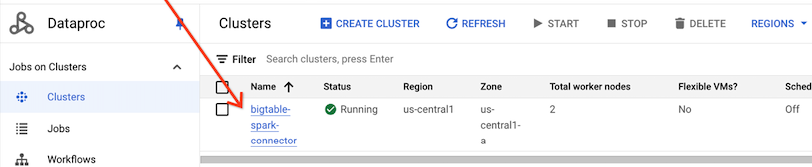

2. Click on the `WEB INTERFACES` tab and then on `JupyterLab` link. For example:</br>
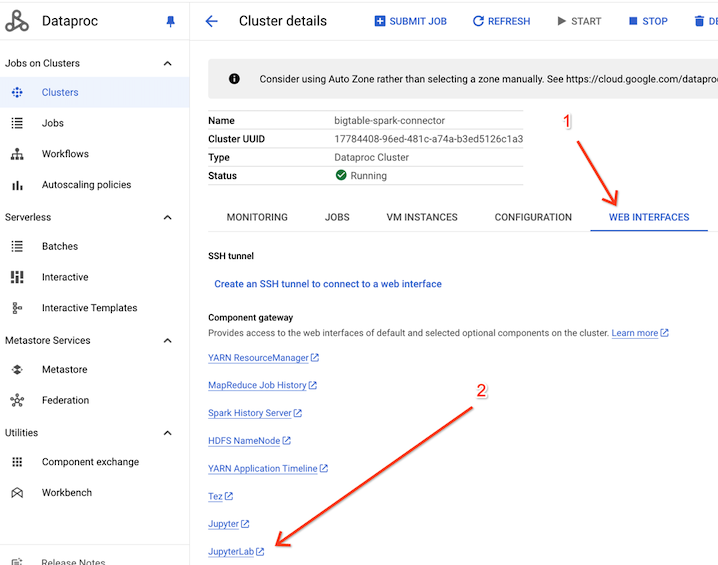

3. You can then upload this notebook on the cluster or create a new one in the desired directory. For example:</br>
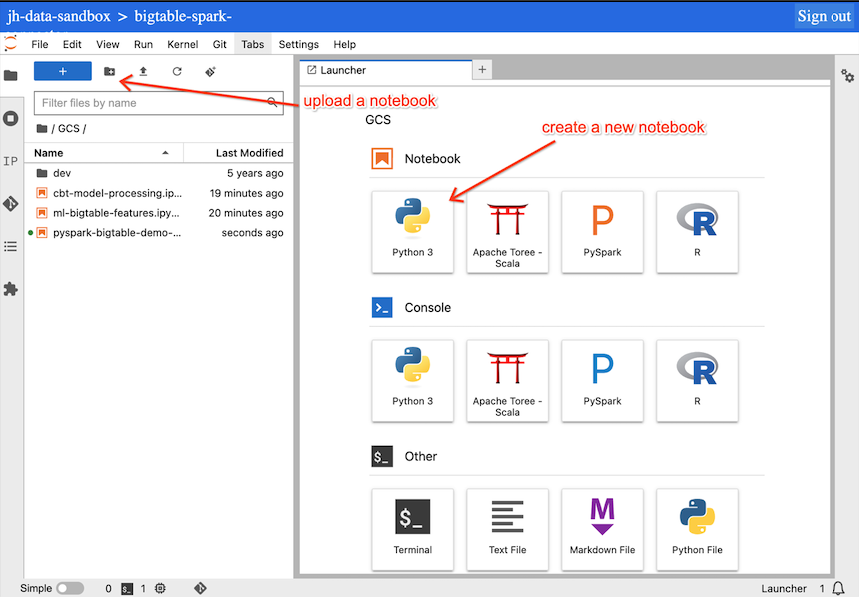

In [ ]:
# Set Environmental Variables
bigtable_project_id = "BIGTABLE_PROJECT_ID"
bigtable_instance_id = "BIGTABLE_INSTANCE_ID"
bigtable_table_name = "example-pyspark-energized-home"
create_new_table = "true"

# Change 2.13 to 2.12 if you want to use spark 2.12
bigtable_spark_connector_jar="gs://spark-lib/bigtable/spark-bigtable_2.13-0.3.0.jar" # ${NEXT_VERSION_FLAG}

In [2]:
# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName("pyspark with bigtable time-series example") \
  .config("spark.jars", bigtable_spark_connector_jar) \
  .config("spark.jars.packages", "org.slf4j:slf4j-reload4j:1.7.36") \
  .getOrCreate()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.slf4j#slf4j-reload4j added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7ae9b82e-d040-499e-ac13-4d0db2a649d3;1.0
	confs: [default]
	found org.slf4j#slf4j-reload4j;1.7.36 in central
	found org.slf4j#slf4j-api;1.7.36 in central
	found ch.qos.reload4j#reload4j;1.2.19 in central
:: resolution report :: resolve 333ms :: artifacts dl 13ms
	:: modules in use:
	ch.qos.reload4j#reload4j;1.2.19 from central in [default]
	org.slf4j#slf4j-api;1.7.36 from central in [default]
	org.slf4j#slf4j-reload4j;1.7.36 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   0 

In [3]:
catalog = "".join(("""{
    "table":{"namespace":"default", "name":"  """ + bigtable_table_name + """ "},
    "rowkey":"id_rowkey",
    "columns":{
        "id_rowkey":{"cf":"rowkey", "col":"id_rowkey", "type":"string"},
        "user_id":{"cf":"info", "col":"user_id", "type":"string"},
        "date_hour":{"cf":"info", "col":"date_hour", "type":"string"},
        "geo":{"cf":"info", "col":"geo", "type":"string"},
        "kwh_produced":{"cf":"info", "col":"kwh_produced", "type":"string"},
        "recommendations":{"cf":"info", "col":"recommendations", "type":"string"},
        "epoch":{"cf":"info", "col":"epoch", "type":"string"}
    }
}""").split())

## PySpark Read/Write + SQL queries
First, we generate a mock DataFrame in Spark, storing electricy production for different users (who we assume have stored solar panels).
For each user (by default 1000 of them), we create 168 hourly production values, corresponding to one week,
starting at 20231205-0000.

The row key in Bigtable is the concatenation of user id and date, e.g., `user_0000000000#20231205-0200`.
We assume that each user is in one `geo` region (`'Americas', 'EMEA', 'APAC'`) and that each row contains a
`recommendations` column, corresponding to their hypothetical smart home device's energy recommendation.
We then run different Spark SQL queries on the data in Bigtable.

In [ ]:
# Generate 7 days (7 * 24 - 1 = 167) of hourly data points from 20231205-0000 (1701734400)
# For 1000 users
number_of_users = 1000
df = spark.sql("""
SELECT rowkey||"#"||date_hour id_rowkey, user_id, date_hour, string(kwh_produced) as kwh_produced,
    ARRAY('Americas', 'EMEA', 'APAC')[MOD(INT(user_id), 2)] geo,
    ARRAY('{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}',
    '{"gateway":["SERVICE_DISCONNECTED"]}', '{"battery":["REPLACE_BATTERY"]}')[MOD(INT(user_id), 2)] recommendations,
    string(epoch) as epoch
FROM (
  SELECT
    rowkey,
    user_id,
    date_format(FROM_UNIXTIME(epoch), 'yyyyMMdd-HHmm') date_hour,
    epoch,
    ROUND(random() + .5, 2) kwh_produced
  FROM (
    SELECT rowkey, user_id, (3600*hours+1701734400) epoch
    FROM (
      SELECT
        'user_'|| lpad(id, 10, "0") rowkey,
        lpad(id, 10, "0") user_id,
        explode(sequence(0, 167)) hours
      FROM range("""+str(number_of_users)+""")
    ) iv
  )
)
""")

df.show(5, truncate=False)

+-----------------------------+----------+-------------+------------+--------+---------------------------------------------------------------------+----------+
|id_rowkey                    |user_id   |date_hour    |kwh_produced|geo     |recommendations                                                      |epoch     |
+-----------------------------+----------+-------------+------------+--------+---------------------------------------------------------------------+----------+
|user_0000000000#20231205-0000|0000000000|20231205-0000|0.58        |Americas|{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}|1701734400|
|user_0000000000#20231205-0100|0000000000|20231205-0100|1.09        |Americas|{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}|1701738000|
|user_0000000000#20231205-0200|0000000000|20231205-0200|1.09        |Americas|{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}|1701741600|
|user_0000000000#20231205-0300|000000000

In [5]:
df.repartition(10) \
  .write \
  .format("bigtable") \
  .options(catalog=catalog) \
  .option("spark.bigtable.project.id", bigtable_project_id) \
  .option("spark.bigtable.instance.id", bigtable_instance_id) \
  .option("spark.bigtable.create.new.table", create_new_table) \
  .save()

In [6]:
records = spark.read \
  .format("bigtable") \
  .option("spark.bigtable.project.id", bigtable_project_id) \
  .option("spark.bigtable.instance.id", bigtable_instance_id) \
  .options(catalog=catalog) \
  .load()
records.createOrReplaceTempView("energized_home_table")

In [7]:
# Get the count of all of the rows in the Bigtable table (uses a full-table scan)
df2 = spark.sql("""SELECT COUNT(*) FROM energized_home_table""")
df2.show(truncate=False)

+--------+
|count(1)|
+--------+
|168000  |
+--------+



In [ ]:
# Get all of the rows corresponding to a user in a time window
#  (partial table scan, since it pushes the row key filter to Bigtable)
df3 = spark.sql("""
SELECT * FROM energized_home_table
    WHERE id_rowkey >= 'user_0000000100#20231205-0800'
        AND id_rowkey < 'user_0000000100#20231205-1400'
""")
df3.show(truncate=False)

+------------+----------+-----------------------------+-------------+---------------------------------------------------------------------+----------+--------+
|kwh_produced|epoch     |id_rowkey                    |date_hour    |recommendations                                                      |user_id   |geo     |
+------------+----------+-----------------------------+-------------+---------------------------------------------------------------------+----------+--------+
|0.92        |1701763200|user_0000000100#20231205-0800|20231205-0800|{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}|0000000100|Americas|
|0.63        |1701766800|user_0000000100#20231205-0900|20231205-0900|{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}|0000000100|Americas|
|0.97        |1701770400|user_0000000100#20231205-1000|20231205-1000|{"battery":["REPLACE_BATTERY"],"gateway":["GATEWAY_VERSION_UPGRADE"]}|0000000100|Americas|
|1.37        |1701774000|user_0000000100

In [ ]:
# Group the data by the geo location and date_hour to roll up production stats
df4 = spark.sql("""
SELECT geo||"#"||date_hour geo_rowkey, geo, date_hour,
    ROUND(SUM(kwh_produced), 2) total_kwh_produced,
    ROUND(AVG(kwh_produced), 2) avg_kwh_produced_hr,
    ROUND(MIN(kwh_produced), 2) min_kwh_produced_hr,
    ROUND(MAX(kwh_produced), 2) max_kwh_produced_hr
FROM energized_home_table
    GROUP BY geo||"#"||date_hour, geo, date_hour
    ORDER BY geo, date_hour
""")
df4.show(5, truncate=False)

+----------------------+--------+-------------+------------------+-------------------+-------------------+-------------------+
|geo_rowkey            |geo     |date_hour    |total_kwh_produced|avg_kwh_produced_hr|min_kwh_produced_hr|max_kwh_produced_hr|
+----------------------+--------+-------------+------------------+-------------------+-------------------+-------------------+
|Americas#20231205-0000|Americas|20231205-0000|508.85            |1.02               |0.5                |1.49               |
|Americas#20231205-0100|Americas|20231205-0100|502.93            |1.01               |0.5                |1.5                |
|Americas#20231205-0200|Americas|20231205-0200|492.33            |0.98               |0.5                |1.49               |
|Americas#20231205-0300|Americas|20231205-0300|504.99            |1.01               |0.5                |1.5                |
|Americas#20231205-0400|Americas|20231205-0400|499.25            |1.0                |0.5                |1.5  

In [10]:
# Store the new roll-up table into Bigtabe, using a new catalog
catalog2 = "".join(("""{
    "table":{"namespace":"default", "name":"  """ + bigtable_table_name + """ _rollup"},
    "rowkey":"geo_rowkey",
    "columns":{
        "geo_rowkey":{"cf":"rowkey", "col":"geo_rowkey", "type":"string"},
        "geo":{"cf":"info", "col":"geo", "type":"string"},
        "date_hour":{"cf":"info", "col":"date_hour", "type":"string"},
        "total_kwh_produced":{"cf":"info", "col":"total_kwh_produced", "type":"string"},
        "avg_kwh_produced_hr":{"cf":"info", "col":"avg_kwh_produced_hr", "type":"string"},
        "min_kwh_produced_hr":{"cf":"info", "col":"min_kwh_produced_hr", "type":"string"},
        "max_kwh_produced_hr":{"cf":"info", "col":"max_kwh_produced_hr", "type":"string"}
    }
}""").split())

df4.write \
  .format("bigtable") \
  .options(catalog=catalog2) \
  .option("spark.bigtable.project.id", bigtable_project_id) \
  .option("spark.bigtable.instance.id", bigtable_instance_id) \
  .option("spark.bigtable.create.new.table", create_new_table) \
  .save()

In [11]:
# Read back the new table from Bigtable
spark.read \
  .format("bigtable") \
  .option("spark.bigtable.project.id", bigtable_project_id) \
  .option("spark.bigtable.instance.id", bigtable_instance_id) \
  .options(catalog=catalog2) \
  .load().show(5, truncate=False)

+------------------+-------------------+-------------------+-------------+-------------------+----------------------+--------+
|total_kwh_produced|min_kwh_produced_hr|avg_kwh_produced_hr|date_hour    |max_kwh_produced_hr|geo_rowkey            |geo     |
+------------------+-------------------+-------------------+-------------+-------------------+----------------------+--------+
|508.85            |0.5                |1.02               |20231205-0000|1.49               |Americas#20231205-0000|Americas|
|502.93            |0.5                |1.01               |20231205-0100|1.5                |Americas#20231205-0100|Americas|
|492.33            |0.5                |0.98               |20231205-0200|1.49               |Americas#20231205-0200|Americas|
|504.99            |0.5                |1.01               |20231205-0300|1.5                |Americas#20231205-0300|Americas|
|499.25            |0.5                |1.0                |20231205-0400|1.5                |Americas#20231205